### Essential Packages

In [2]:
import random
import itertools
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib.lines import Line2D

### Minesweeper Class

In [7]:
class MineSweeper:
    def __init__(self, rows, cols, n_mines, seed=None):
        self.rows = rows
        self.cols = cols
        self.n_mines = n_mines
        self.seed = seed
        self.rng = random.Random(seed)

        # Game state
        self.mines = set()
        self.revealed = set()
        self.numbers = {}
        self.game_over = False
        self.first_move = True

    def _get_neighbors(self, row, col):
        """Get all valid neighbor coordinates"""
        neighbors = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                nr, nc = row + dr, col + dc
                if 0 <= nr < self.rows and 0 <= nc < self.cols:
                    neighbors.append((nr, nc))
        return neighbors

    def _place_mines(self, safe_row, safe_col):
        """Place mines, avoiding the first clicked cell and its neighbors"""
        safe_zone = {(safe_row, safe_col)}
        safe_zone.update(self._get_neighbors(safe_row, safe_col))

        all_positions = []
        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) not in safe_zone:
                    all_positions.append((r, c))

        if len(all_positions) < self.n_mines:
            raise ValueError(
                f"Cannot place {self.n_mines} mines with current safe zone"
            )

        mine_positions = self.rng.sample(all_positions, self.n_mines)
        self.mines = set(mine_positions)

        self.numbers = {}
        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) not in self.mines:
                    count = sum(
                        1
                        for nr, nc in self._get_neighbors(r, c)
                        if (nr, nc) in self.mines
                    )
                    self.numbers[(r, c)] = count

    def reveal(self, row, col):
        """Reveal a cell. Returns the number or 'MINE'"""
        if self.game_over or (row, col) in self.revealed:
            return self.numbers.get((row, col), 0)

        if self.first_move:
            self._place_mines(row, col)
            self.first_move = False

        if (row, col) in self.mines:
            self.game_over = True
            return "MINE"

        to_reveal = deque([(row, col)])
        while to_reveal:
            r, c = to_reveal.popleft()
            if (r, c) in self.revealed:
                continue

            self.revealed.add((r, c))

            if self.numbers[(r, c)] == 0:
                for nr, nc in self._get_neighbors(r, c):
                    if (nr, nc) not in self.revealed and (nr, nc) not in self.mines:
                        to_reveal.append((nr, nc))

        return self.numbers[(row, col)]

    def is_win(self):
        """Check if the game is won"""
        return not self.game_over and len(self.revealed) == (
            self.rows * self.cols - self.n_mines
        )

## 🎇 Solver in focus: **TRIMS** 

In [8]:
class AdvancedMinesweeperSolver:
    def __init__(self, rows, cols, *, seed=None):
        self.rows = rows
        self.cols = cols
        # Estimate total mines based on standard difficulty levels
        total_cells = rows * cols
        if total_cells <= 81:  # Beginner (9x9)
            self.total_mines = 10
        elif total_cells <= 256:  # Intermediate (16x16)
            self.total_mines = 40
        else:  # Expert (16x30 or larger)
            self.total_mines = 99

        self.rng = random.Random(seed)
        self.flagged_mines = set()
        self.mine_probabilities = {}

    def _get_neighbors(self, row, col):
        return [
            (row + dr, col + dc)
            for dr in [-1, 0, 1]
            for dc in [-1, 0, 1]
            if (dr != 0 or dc != 0)
            and 0 <= row + dr < self.rows
            and 0 <= col + dc < self.cols
        ]

    def solve(self, game):
        # Smart opening: start with corner or center
        if not game.revealed:
            if self.rows >= 9 and self.cols >= 9:
                opening_cell = (0, 0)  # Corner for larger boards
            else:
                opening_cell = (
                    self.rows // 2,
                    self.cols // 2,
                )  # Center for small boards

            if game.reveal(*opening_cell) == "MINE":
                return False

        max_iterations = 200  # Reduced to prevent infinite loops
        stall_count = 0

        for iteration in range(max_iterations):
            if game.is_win():
                return True

            progress_made = False

            # Phase 1: Fast deterministic solving
            safe_cells, mine_cells = self._fast_constraint_solve(game)

            if mine_cells:
                self.flagged_mines.update(mine_cells)
                progress_made = True

            if safe_cells:
                for row, col in safe_cells:
                    if (row, col) not in game.revealed:
                        result = game.reveal(row, col)
                        if result == "MINE":
                            return False
                        if game.is_win():
                            return True
                        progress_made = True

            # Phase 2: Probability-based move if no deterministic moves
            if not progress_made:
                best_move = self._find_best_probability_move(game)
                if best_move:
                    row, col = best_move
                    result = game.reveal(row, col)
                    if result == "MINE":
                        return False
                    if game.is_win():
                        return True
                    progress_made = True

            # Track stalling to prevent infinite loops
            if not progress_made:
                stall_count += 1
                if stall_count >= 3:  # If stalled for 3 iterations, make random move
                    random_move = self._make_emergency_move(game)
                    if random_move:
                        row, col = random_move
                        result = game.reveal(row, col)
                        if result == "MINE":
                            return False
                        if game.is_win():
                            return True
                        stall_count = 0
                    else:
                        break
            else:
                stall_count = 0

        return game.is_win()

    def _fast_constraint_solve(self, game):
        """Fast constraint solving with basic techniques"""
        safe_cells = set()
        mine_cells = set()

        # Build constraints from revealed numbers
        constraints = []
        for (row, col), number in game.numbers.items():
            if (row, col) in game.revealed:
                neighbors = self._get_neighbors(row, col)
                unrevealed = [
                    n
                    for n in neighbors
                    if n not in game.revealed and n not in self.flagged_mines
                ]
                flagged_count = sum(1 for n in neighbors if n in self.flagged_mines)
                remaining_mines = number - flagged_count

                if unrevealed and remaining_mines >= 0:
                    constraints.append((unrevealed, remaining_mines))

        # Apply basic constraint propagation
        for unrevealed, target in constraints:
            if target == 0:
                # All remaining cells are safe
                safe_cells.update(unrevealed)
            elif target == len(unrevealed):
                # All remaining cells are mines
                mine_cells.update(unrevealed)

        # Advanced: Try small constraint combinations (limited for performance)
        if not safe_cells and not mine_cells:
            advanced_safe, advanced_mines = self._solve_small_constraint_groups(
                constraints
            )
            safe_cells.update(advanced_safe)
            mine_cells.update(advanced_mines)

        return safe_cells, mine_cells

    def _solve_small_constraint_groups(self, constraints):
        """Solve small groups of overlapping constraints"""
        safe_cells = set()
        mine_cells = set()

        # Only process small constraint groups to avoid performance issues
        for i, (cells1, target1) in enumerate(constraints):
            for j, (cells2, target2) in enumerate(constraints[i + 1 :], i + 1):
                overlap = set(cells1) & set(cells2)
                if overlap and len(cells1) + len(cells2) <= 8:  # Small groups only
                    # Try to solve this pair of constraints
                    all_cells = list(set(cells1) | set(cells2))

                    # Brute force for small sets
                    if len(all_cells) <= 6:
                        valid_configs = []
                        for mine_count in range(len(all_cells) + 1):
                            for mine_combo in itertools.combinations(
                                all_cells, mine_count
                            ):
                                mine_set = set(mine_combo)

                                # Check if satisfies both constraints
                                mines1 = sum(1 for cell in cells1 if cell in mine_set)
                                mines2 = sum(1 for cell in cells2 if cell in mine_set)

                                if mines1 == target1 and mines2 == target2:
                                    valid_configs.append(mine_set)

                        # Find cells that are always mines or always safe
                        if valid_configs:
                            always_mines = set(all_cells)
                            always_safe = set(all_cells)

                            for config in valid_configs:
                                always_mines &= config
                                always_safe &= set(all_cells) - config

                            safe_cells.update(always_safe)
                            mine_cells.update(always_mines)

                            if safe_cells or mine_cells:
                                return safe_cells, mine_cells

        return safe_cells, mine_cells

    def _find_best_probability_move(self, game):
        """Find best move using probability analysis"""
        unrevealed_cells = [
            (r, c)
            for r in range(self.rows)
            for c in range(self.cols)
            if (r, c) not in game.revealed and (r, c) not in self.flagged_mines
        ]

        if not unrevealed_cells:
            return None

        # Calculate probabilities for each cell
        cell_probabilities = []
        for row, col in unrevealed_cells:
            prob = self._calculate_mine_probability(game, row, col)
            info_value = self._calculate_information_value(game, row, col)
            cell_probabilities.append(
                (prob, -info_value, row, col)
            )  # Negative for sorting

        # Sort by probability (ascending), then by information value (descending)
        cell_probabilities.sort()

        # Return the best cell (lowest probability, highest info value)
        return (cell_probabilities[0][2], cell_probabilities[0][3])

    def _calculate_mine_probability(self, game, row, col):
        """Calculate probability that a cell contains a mine"""
        neighbors = self._get_neighbors(row, col)
        constraint_probs = []

        # Local constraint analysis
        for nr, nc in neighbors:
            if (nr, nc) in game.numbers:
                number = game.numbers[(nr, nc)]
                neighbor_neighbors = self._get_neighbors(nr, nc)

                unrevealed = [
                    n
                    for n in neighbor_neighbors
                    if n not in game.revealed and n not in self.flagged_mines
                ]
                flagged = sum(1 for n in neighbor_neighbors if n in self.flagged_mines)

                if unrevealed:
                    remaining_mines = number - flagged
                    local_prob = max(0, min(1, remaining_mines / len(unrevealed)))
                    constraint_probs.append(local_prob)

        # Calculate local probability
        local_prob = (
            sum(constraint_probs) / len(constraint_probs) if constraint_probs else 0.3
        )

        # Global probability based on remaining mines
        total_flagged = len(self.flagged_mines)
        total_revealed = len(game.revealed)
        remaining_mines = self.total_mines - total_flagged
        remaining_cells = self.rows * self.cols - total_revealed - total_flagged
        global_prob = remaining_mines / remaining_cells if remaining_cells > 0 else 0

        # Edge/corner bonus (these are statistically safer)
        position_factor = 1.0
        if self._is_corner(row, col):
            position_factor = 0.7
        elif self._is_edge(row, col):
            position_factor = 0.85

        # Weighted combination
        if constraint_probs:
            combined_prob = 0.7 * local_prob + 0.3 * global_prob
        else:
            combined_prob = global_prob

        return combined_prob * position_factor

    def _calculate_information_value(self, game, row, col):
        """Calculate information value of revealing this cell"""
        neighbors = self._get_neighbors(row, col)
        unrevealed_neighbors = sum(
            1
            for nr, nc in neighbors
            if (nr, nc) not in game.revealed and (nr, nc) not in self.flagged_mines
        )
        return unrevealed_neighbors

    def _is_corner(self, row, col):
        """Check if cell is a corner"""
        return (row == 0 or row == self.rows - 1) and (col == 0 or col == self.cols - 1)

    def _is_edge(self, row, col):
        """Check if cell is on an edge"""
        return row == 0 or row == self.rows - 1 or col == 0 or col == self.cols - 1

    def _make_emergency_move(self, game):
        """Make a random move when stuck"""
        unrevealed_cells = [
            (r, c)
            for r in range(self.rows)
            for c in range(self.cols)
            if (r, c) not in game.revealed and (r, c) not in self.flagged_mines
        ]

        if not unrevealed_cells:
            return None

        # Prefer corner/edge cells if available
        corners = [cell for cell in unrevealed_cells if self._is_corner(*cell)]
        if corners:
            return self.rng.choice(corners)

        edges = [cell for cell in unrevealed_cells if self._is_edge(*cell)]
        if edges:
            return self.rng.choice(edges)

        return self.rng.choice(unrevealed_cells)

In [9]:
class PAFGSolver:
    def __init__(self, rows, cols, *, seed=None):
        self.rows = rows
        self.cols = cols
        self.rng = random.Random(seed)
        self.flagged = set()  # Internally tracked flagged cells

    def solve(self, game):
        self.flagged.clear()

        while not game.is_win():
            B = self.get_border_cells(game)
            if not B:
                row, col = self.first_action()
                result = game.reveal(row, col)
                if result == "MINE":
                    return False
                continue

            S_safe, S_mine = self.primary_reasoning(game, B)
            if S_safe or S_mine:
                self.apply_deductions(game, S_safe, S_mine)
                continue

            S_safe, S_mine, _, _ = self.advanced_reasoning(game, B)
            if S_safe or S_mine:
                self.apply_deductions(game, S_safe, S_mine)
                continue

            guess_cell = self.guess(game)
            result = game.reveal(*guess_cell)
            if result == "MINE":
                return False

        return True

    def first_action(self):
        return (0, 0)  # Choose top-left corner for maximal zero-propagation

    def get_neighbors(self, r, c):
        return [
            (nr, nc)
            for nr in range(r - 1, r + 2)
            for nc in range(c - 1, c + 2)
            if 0 <= nr < self.rows and 0 <= nc < self.cols and (nr, nc) != (r, c)
        ]

    def get_border_cells(self, game):
        border = set()
        for r, c in game.revealed:
            neighbors = self.get_neighbors(r, c)
            if any((nr, nc) not in game.revealed for (nr, nc) in neighbors):
                border.add((r, c))
        return border

    def primary_reasoning(self, game, B):
        S_safe = set()
        S_mine = set()
        for r, c in B:
            number = game.numbers.get((r, c), 0)
            neighbors = self.get_neighbors(r, c)
            f_star = {(nr, nc) for (nr, nc) in neighbors if (nr, nc) in self.flagged}
            h_star = {
                (nr, nc)
                for (nr, nc) in neighbors
                if (nr, nc) not in game.revealed and (nr, nc) not in self.flagged
            }

            if len(h_star) == number - len(f_star) and len(h_star) > 0:
                S_mine |= h_star
            elif number == len(f_star) and len(h_star) > 0:
                S_safe |= h_star
        return S_safe, S_mine

    def advanced_reasoning(self, game, B):
        eqs = []
        vars_map = {}
        var_idx = 0

        for r, c in B:
            number = game.numbers.get((r, c), 0)
            neighbors = self.get_neighbors(r, c)
            hidden = []
            flagged_count = 0
            for nr, nc in neighbors:
                if (nr, nc) in self.flagged:
                    flagged_count += 1
                elif (nr, nc) not in game.revealed:
                    if (nr, nc) not in vars_map:
                        vars_map[(nr, nc)] = var_idx
                        var_idx += 1
                    hidden.append(vars_map[(nr, nc)])

            if hidden:
                eq_row = [0] * var_idx
                for idx in hidden:
                    eq_row[idx] = 1
                eqs.append((eq_row, number - flagged_count))

        if not eqs:
            return set(), set(), None, None

        A = []
        b = []
        for row, val in eqs:
            row_extended = row + [0] * (var_idx - len(row))
            A.append(row_extended)
            b.append(val)

        A = np.array(A, dtype=float)
        b = np.array(b, dtype=float).reshape(-1, 1)

        try:
            Ab = np.hstack([A, b])
            self.gauss_jordan(Ab)
        except:
            return set(), set(), None, None

        safe_set = set()
        mine_set = set()

        for row in Ab:
            coeffs = row[:-1]
            const = row[-1]
            nonzero = [i for i, val in enumerate(coeffs) if abs(val) > 1e-5]
            if not nonzero:
                continue
            total = sum(coeffs[i] for i in nonzero)

            if all(coeffs[i] > 0 for i in nonzero):
                if abs(total - const) < 1e-5:
                    for i in nonzero:
                        for cell, idx in vars_map.items():
                            if idx == i:
                                mine_set.add(cell)
                elif abs(const) < 1e-5:
                    for i in nonzero:
                        for cell, idx in vars_map.items():
                            if idx == i:
                                safe_set.add(cell)

        return safe_set, mine_set, Ab[:, :-1], vars_map

    def gauss_jordan(self, mat):
        rows, cols = mat.shape
        for i in range(min(rows, cols - 1)):
            pivot = max(range(i, rows), key=lambda r: abs(mat[r, i]))
            if abs(mat[pivot, i]) < 1e-5:
                continue
            if pivot != i:
                mat[[i, pivot]] = mat[[pivot, i]]
            mat[i] = mat[i] / mat[i, i]
            for j in range(rows):
                if j != i and abs(mat[j, i]) > 1e-5:
                    mat[j] -= mat[i] * mat[j, i]

    def guess(self, game):
        hidden = [
            (r, c)
            for r in range(self.rows)
            for c in range(self.cols)
            if (r, c) not in game.revealed and (r, c) not in self.flagged
        ]
        return self.rng.choice(hidden)

    def apply_deductions(self, game, safe_set, mine_set):
        self.flagged |= mine_set  # Track mines internally
        for r, c in safe_set:
            result = game.reveal(r, c)
            if result == "MINE":
                raise RuntimeError(f"Wrong deduction: ({r}, {c}) was a mine.")


## 🧪 Run Extensive Tests

In [10]:
# Get user-defined number of iterations (seeds)
while True:
    try:
        n_trials = int(input("Enter number of seeds to test (e.g., 10): ").strip())
        if n_trials <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer.")

# Test configurations: (rows, cols, mines, label)
configs = [(9, 9, 10, "Beginner"), (16, 16, 40, "Intermediate"), (16, 30, 99, "Expert")]

# Store results
summary_results = []

print("\n=== Running TRIMS Solver Benchmark ===\n")

for rows, cols, mines, label in configs:
    wins = 0
    total_moves = 0
    print(f"\n--- {label} Difficulty ({rows}x{cols}, {mines} mines) ---")

    for seed in range(1, n_trials + 1):
        try:
            game = MineSweeper(rows, cols, mines, seed=seed)
            solver = AdvancedMinesweeperSolver(rows, cols, seed=seed)
            result = solver.solve(game)

            move_count = len(game.revealed)
            total_moves += move_count
            if result:
                wins += 1
                print(f"Seed {seed:3d}: ✅ Win  | Moves: {move_count}")
            else:
                print(f"Seed {seed:3d}: ❌ Loss | Moves: {move_count}")

        except Exception as e:
            print(f"Seed {seed:3d}: ⚠️ Error - {e}")

    win_rate = wins / n_trials
    avg_moves = total_moves / n_trials
    summary_results.append(
        (label, rows, cols, mines, wins, n_trials, win_rate, avg_moves)
    )

# Final summary as NumPy array
results_array = np.array(summary_results, dtype=object)

print(
    "\n=== Final Summary (Label, Rows, Cols, Mines, Wins, Trials, WinRate, AvgMoves) ==="
)
print(results_array)


=== Running TRIMS Solver Benchmark ===


--- Beginner Difficulty (9x9, 10 mines) ---
Seed   1: ✅ Win  | Moves: 71
Seed   2: ✅ Win  | Moves: 71
Seed   3: ✅ Win  | Moves: 71
Seed   4: ✅ Win  | Moves: 71
Seed   5: ✅ Win  | Moves: 71
Seed   6: ✅ Win  | Moves: 71
Seed   7: ✅ Win  | Moves: 71
Seed   8: ✅ Win  | Moves: 71
Seed   9: ✅ Win  | Moves: 71
Seed  10: ✅ Win  | Moves: 71
Seed  11: ✅ Win  | Moves: 71
Seed  12: ✅ Win  | Moves: 71
Seed  13: ✅ Win  | Moves: 71
Seed  14: ✅ Win  | Moves: 71
Seed  15: ✅ Win  | Moves: 71
Seed  16: ✅ Win  | Moves: 71
Seed  17: ✅ Win  | Moves: 71
Seed  18: ✅ Win  | Moves: 71
Seed  19: ✅ Win  | Moves: 71
Seed  20: ✅ Win  | Moves: 71
Seed  21: ✅ Win  | Moves: 71
Seed  22: ✅ Win  | Moves: 71
Seed  23: ✅ Win  | Moves: 71
Seed  24: ✅ Win  | Moves: 71
Seed  25: ✅ Win  | Moves: 71
Seed  26: ✅ Win  | Moves: 71
Seed  27: ✅ Win  | Moves: 71
Seed  28: ✅ Win  | Moves: 71
Seed  29: ✅ Win  | Moves: 71
Seed  30: ✅ Win  | Moves: 71
Seed  31: ✅ Win  | Moves: 71
Seed  32: ✅ Win

## 📊 Comparison between TRIMS and other State of the Art Solvers

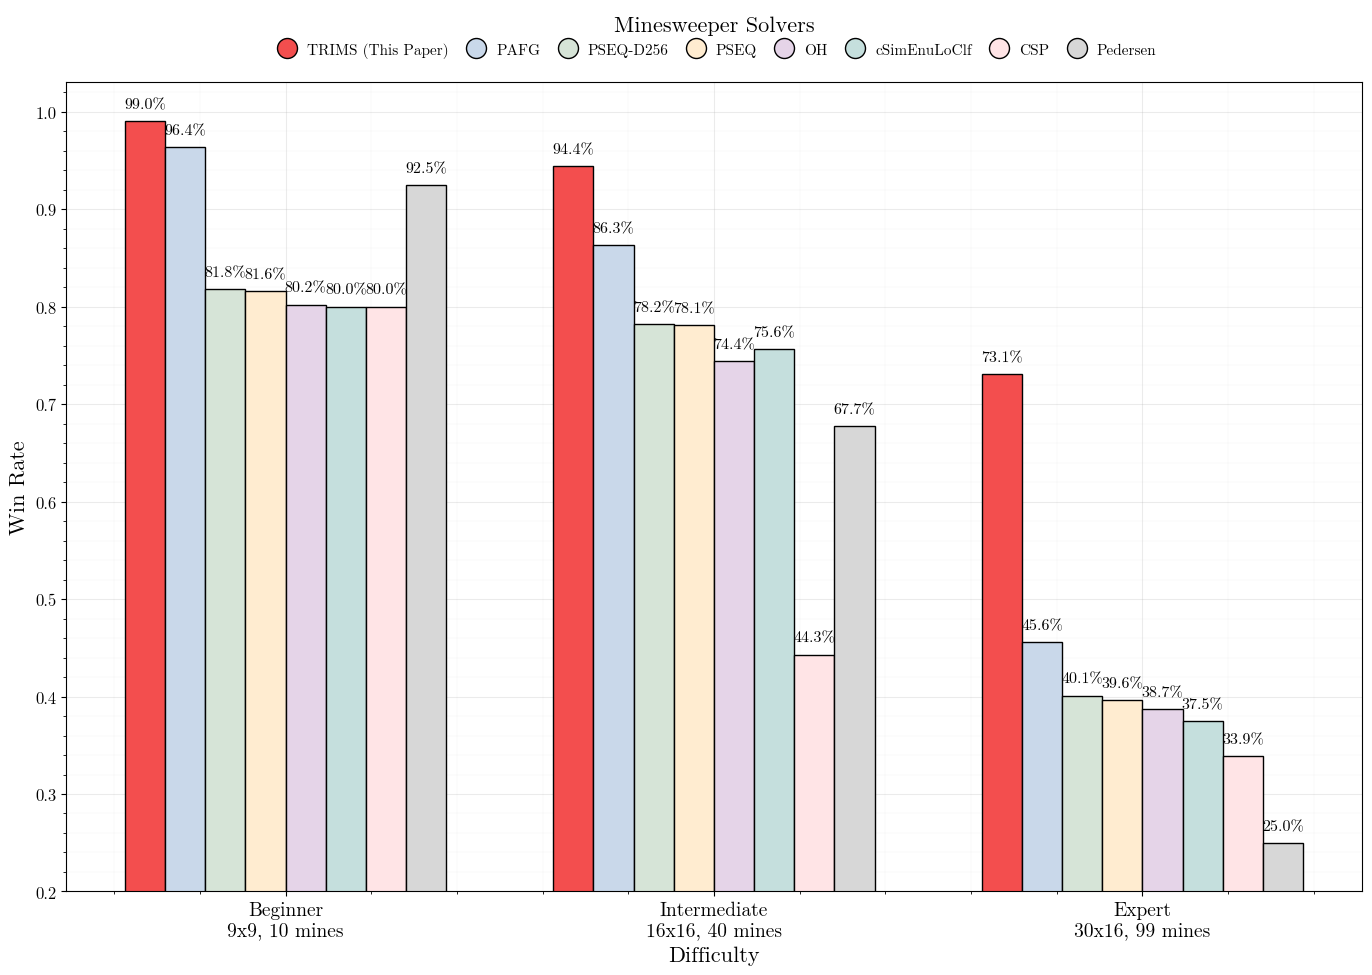

In [15]:
# Path to custom font file (OTF)
font_path = "./Fonts/lmroman10-regular.otf"

# Create a font entry from the font file
font_entry = fm.FontEntry(fname=font_path, name="CustomFont")
fm.fontManager.ttflist.append(font_entry)

custom_colors = [
    "#F34E4E",  # Dusty rose
    "#C9D8EA",  # Soft powder blue
    "#D6E4D7",  # Sage green
    "#FFECD0",  # Warm peach
    "#E5D4E8",  # Soft lavender
    "#C5DFDD",  # Mint green
    "#FFE4E6",  # Blush pink
    "#D7D7D7",  # Warm taupe
    "#F7DBE9",  # Soft coral pink
]

# 1. Define mock `results` data
results = {
    "Beginner": {
        "TRIMS (This Paper)": {"win_rate": 0.99},
        "PAFG": {"win_rate": 0.964},
        "PSEQ-D256": {"win_rate": 0.818},
        "PSEQ": {"win_rate": 0.816},
        "OH": {"win_rate": 0.802},
        "cSimEnuLoClf": {"win_rate": 0.8},
        "CSP": {"win_rate": 0.8},
        "Pedersen": {"win_rate": 0.925},
    },
    "Intermediate": {
        "TRIMS (This Paper)": {"win_rate": 0.944},
        "PAFG": {"win_rate": 0.863},
        "PSEQ-D256": {"win_rate": 0.782},
        "PSEQ": {"win_rate": 0.781},
        "OH": {"win_rate": 0.744},
        "cSimEnuLoClf": {"win_rate": 0.756},
        "CSP": {"win_rate": 0.443},
        "CSCSP": {"win_rate": 0.759},
        "Pedersen": {"win_rate": 0.677},
    },
    "Expert": {
        "TRIMS (This Paper)": {"win_rate": 0.731},
        "PAFG": {"win_rate": 0.456},
        "PSEQ-D256": {"win_rate": 0.401},
        "PSEQ": {"win_rate": 0.396},
        "OH": {"win_rate": 0.387},
        "cSimEnuLoClf": {"win_rate": 0.375},
        "CSP": {"win_rate": 0.339},
        "CSCSP": {"win_rate": 0.329},
        "Pedersen": {"win_rate": 0.250},
    },
}


# 2. Define the plotting function (horizontal bar version)
def plot_solver_winrates(results, plot_type):
    difficulties = ["Beginner", "Intermediate", "Expert"]
    solvers = list(results["Beginner"].keys())

    winrate_matrix = []
    for solver in solvers:
        winrates = []
        for difficulty in difficulties:
            config = results.get(difficulty, {})
            stats = config.get(solver)
            winrates.append(stats["win_rate"] if stats else 0)
        winrate_matrix.append(winrates)
    winrate_matrix = np.array(winrate_matrix)

    # Update rcParams to use it
    mpl.rcParams.update(
        {
            "font.family": "CustomFont",
            "font.size": 16,
            "axes.titlesize": 18,
            "axes.labelsize": 16,
            "xtick.labelsize": 14,
            "ytick.labelsize": 12,
            "legend.fontsize": 13,
            "figure.titlesize": 18,
        }
    )

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlabel("Difficulty")
    ax.set_ylabel("Win Rate")

    # Set y-axis to start at 0.2 instead of 0.0
    ax.set_ylim(bottom=0.2, top=1.03)

    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.minorticks_on()
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.set_axisbelow(True)

    if plot_type == "grouped_bar":
        x = np.arange(len(difficulties))
        bar_width = 0.75 / len(solvers)
        bars = []

        for i, solver in enumerate(solvers):
            bar = ax.bar(
                x + i * bar_width,
                winrate_matrix[i],
                width=bar_width,
                label=solver,
                color=custom_colors[i],
                edgecolor="black",
                linewidth=1.0,
            )
            bars.append(bar)

            # Add percentage text above each bar
            for j, (bar_rect, value) in enumerate(zip(bar, winrate_matrix[i])):
                height = bar_rect.get_height()
                ax.text(
                    bar_rect.get_x() + bar_rect.get_width() / 2,
                    height + 0.01,
                    f"{value:.1%}",
                    ha="center",
                    va="bottom",
                    fontsize=11.5,
                    fontweight="bold",
                    color="black",
                )

        ax.set_xticks(x + (len(solvers) - 1) * bar_width / 2)
        # Create custom x-tick labels with grid size and mine count
        difficulty_labels = [
            "Beginner\n9x9, 10 mines",
            "Intermediate\n16x16, 40 mines",
            "Expert\n30x16, 99 mines",
        ]
        ax.set_xticklabels(difficulty_labels)

    else:
        raise ValueError(f"Unsupported plot_type: {plot_type}")

    # Create custom legend handles: square markers
    legend_handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"{solver}",
            markerfacecolor=custom_colors[i],
            markeredgecolor="black",
            markersize=12,
        )
        for i, solver in enumerate(solvers)
    ]

    # Add custom legend
    ax.legend(
        handles=legend_handles,
        title="Minesweeper Solvers",
        fontsize=11,
        bbox_to_anchor=(0.5, 1.1),
        loc="upper center",
        ncol=len(solvers),
        frameon=False,
        handletextpad=0.3,
        columnspacing=0.8,
        markerscale=1.2,
    )

    plt.tight_layout()
    plt.show()


# 3. Now call the function
plot_solver_winrates(results, plot_type="grouped_bar")